In [ ]:
# Home task: 
# explore whether there are any dependences between reading/writing/math_scores
# and 
# find out whether student's race or/and paretns' level_of_education influences lunch_type of their children
# and 
# attach all proving plots

## Imports

In [124]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import normaltest
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from numpy import cov
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

## Data

In [125]:
student_perform = pd.read_csv("./StudentsPerformance.csv")
student_perform.columns = [x.replace(" ", "_") for x in student_perform.columns]
student_perform.head()

,gender,race/ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## Functions

In [126]:
def check_normal(values):
    stat, p = normaltest(values)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Sample looks normal')
    else:
        print('Sample does not look normal')

In [127]:
# function for calulating Cramer`s statistic (for categorical data)
# This function is from https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

## 1st task

In [128]:
# Firstly, we filter only useful for us columns
scores = student_perform.filter(like="score")
scores

,math_score,reading_score,writing_score
0,72,72,74
1,69,90,88
2,90,95,93
3,47,57,44
4,76,78,75
...,...,...,...
995,88,99,95
996,62,55,55
997,59,71,65
998,68,78,77


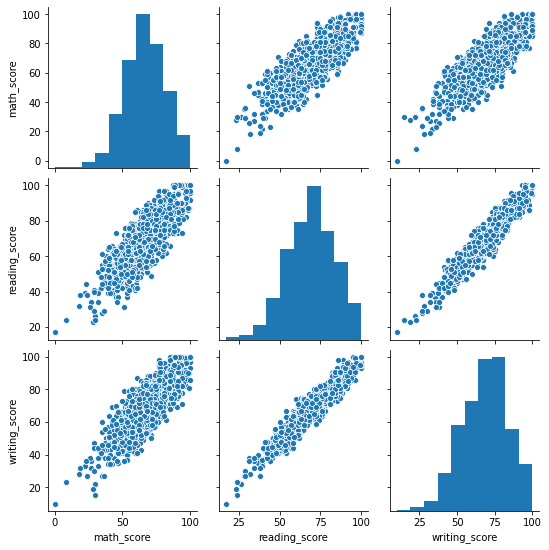

In [129]:
# Now we want to see both distribution of single variables and relationships between each two variables

sns.pairplot(scores)

# The shape of all three variables is close to normal bell-shaped distribution, 
# but we can notice, that each distribution is a bit skewed. We should check the normality for further
# analysis.
# Besides, we notice that there are some dependencies between all variables, but probably
# the dependency of reading score and writing score is the strongest. We will check it later.

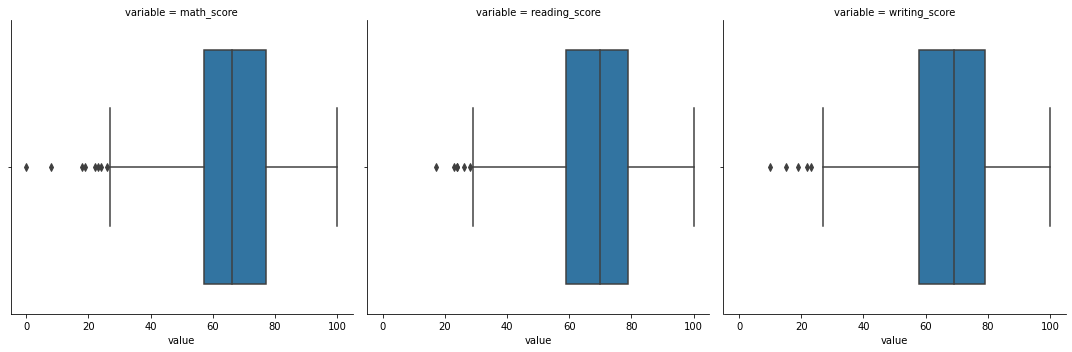

In [130]:
# For checking normality we draw some bowplots (melting the data before it)
scores_melt = scores.melt()
sns.catplot(data = scores_melt, x = 'value', col = 'variable', kind='box')

# The boxplots look skewed as well

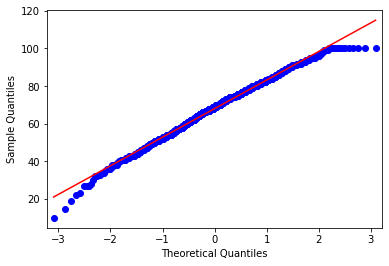

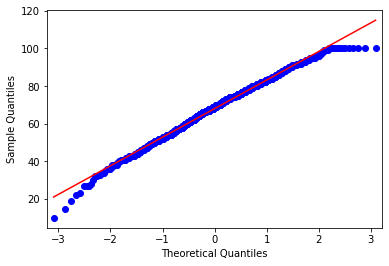

In [131]:
# Finally, we use Q-Q plot to chech the distribution of variables
qqplot(scores['writing_score'], line='s')

# Now we can definately assume that the data is distributed unnormal

In [132]:
# We can check normality using special normality test
check_normal(scores['writing_score'])

Statistics=13.606, p=0.001
Sample does not look normal


In [133]:
check_normal(scores['reading_score'])

Statistics=11.117, p=0.004
Sample does not look normal


In [134]:
check_normal(scores['math_score'])
# Looks like none of our variables is normally distributed. That is why we can use only non-parametrical tests 
# for searching any dependency. 

Statistics=15.409, p=0.000
Sample does not look normal


In [135]:
# Now we can calculate covariance between variables. Our distribution is not normal, 
# but it is bell-shaped and Gaussion-like, so we can try to use covariance. 
# Covariance is a basic metric of  a linear relationship.
# It is calculated as the average of the product between the values from each sample,
# where the values haven been centered.

covariance = cov(scores.T)
covariance

# The sign of the covariance can be interpreted as whether the two variables change in the same
# direction (positive) or change in different directions (negative).
# A covariance value of zero indicates that both variables are completely independent.

# In our case, we cannot easily interprete the power of covariance, but probably there is some,
# because otherwise we would have zeroes in covariance matrix. 

array([[229.918998  , 180.99895796, 184.93913313],
       [180.99895796, 213.1656046 , 211.78666066],
       [184.93913313, 211.78666066, 230.90799199]])

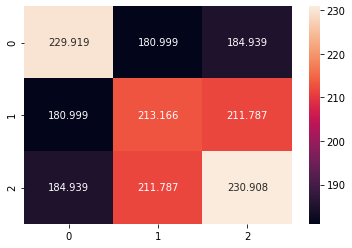

In [136]:
# It is easier to discover covariance with heatmap. 
sns.heatmap(covariance, annot=True, fmt='g')

# We can see, that the covariance between writing score and reading score is the strongest again

In [137]:
# As the variables are not normally dostributed, we will use Spearman coef. to test whether the variables are 
# correlated or not. The scores are between -1 and 1 for perfectly negatively correlated variables and 
# perfectly positively correlated respectively.
corr, p = spearmanr(scores)
corr, p

# Writing and reading skills are strongly correlated again. The correlation between math and smth else
# is not so strong, but it exists as well

(array([[1.        , 0.80406389, 0.77833859],
        [0.80406389, 1.        , 0.94895252],
        [0.77833859, 0.94895252, 1.        ]]),
 array([[0.00000000e+000, 1.35385149e-227, 5.85305897e-204],
        [1.35385149e-227, 0.00000000e+000, 0.00000000e+000],
        [5.85305897e-204, 0.00000000e+000, 0.00000000e+000]]))

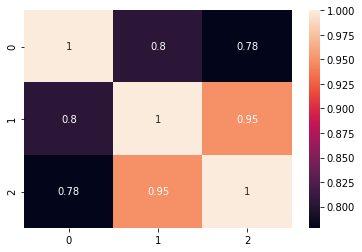

In [138]:
# Heatmap of correlation coefficients
sns.heatmap(corr, annot=True)

In [139]:
# To check the correlation between writing and reading skills, we can build simple regression model 
# and predict the values in test dataset. Linear regression analysis
# does not assume normality for either predictors or an outcome, so we can perform it on our data. 
# Probably, we can check normality of errors after modeling. In linear regression, errors 
# are assumed to follow a normal distribution with a mean of zero.

# We divide our data to train and test dataset
X_train, X_test, y_train, y_test = train_test_split(scores['reading_score'].values.reshape(-1,1),
                                                    scores['writing_score'].values.reshape(-1,1), 
                                                    test_size=0.2, random_state=0)

# Than we train the algorithm
regressor = LinearRegression()  
regressor.fit(X_train, y_train) 

# and retrieve the slope
print(regressor.coef_)

y_pred = regressor.predict(X_test)

[[0.99615791]]


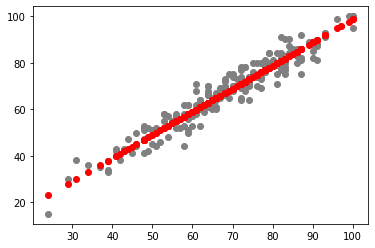

In [140]:
# Now we can visualise real values and predicted values on the one plot

plt.scatter(X_test, y_test,  color='gray')
plt.scatter(X_test, y_pred, color='red')

In [141]:
# the df with both actual and predicted values
df_ = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df_

,Actual,Predicted
0,74,70.830001
1,72,71.826159
2,50,44.929895
3,64,60.868422
4,76,76.806948
...,...,...
195,60,59.872264
196,88,88.760843
197,75,81.787738
198,74,68.837685


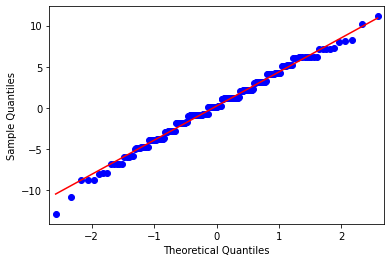

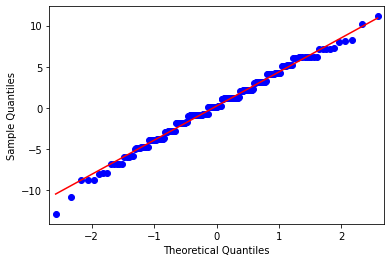

In [142]:
# We should check the distribution of residuals
resid = (df_['Actual'] - df_['Predicted'])
qqplot(resid, line='s')

# Looks like residuals are normally distributed, all is correct.

## Task 2 

In [143]:
# Firstly, we filter the data for this task

df = student_perform.drop(['gender', 'test_preparation_course', 'math_score', 
                          'reading_score', 'writing_score'], axis=1)
df["parental_level_of_education"].replace({'some high school':'high school'}, inplace = True)
df['val'] = 1
df

,race/ethnicity,parental_level_of_education,lunch,val
0,group B,bachelor's degree,standard,1
1,group C,some college,standard,1
2,group B,master's degree,standard,1
3,group A,associate's degree,free/reduced,1
4,group C,some college,standard,1
...,...,...,...,...
995,group E,master's degree,standard,1
996,group C,high school,free/reduced,1
997,group C,high school,free/reduced,1
998,group D,some college,standard,1


In [144]:
# dataset with level of education, lunch and counts

df_ed = df.groupby(["parental_level_of_education", "lunch"], as_index=False).count().\
drop(['race/ethnicity'], axis = 1)
df_ed

,parental_level_of_education,lunch,val
0,associate's degree,free/reduced,77
1,associate's degree,standard,145
2,bachelor's degree,free/reduced,44
3,bachelor's degree,standard,74
4,high school,free/reduced,131
5,high school,standard,244
6,master's degree,free/reduced,24
7,master's degree,standard,35
8,some college,free/reduced,79
9,some college,standard,147


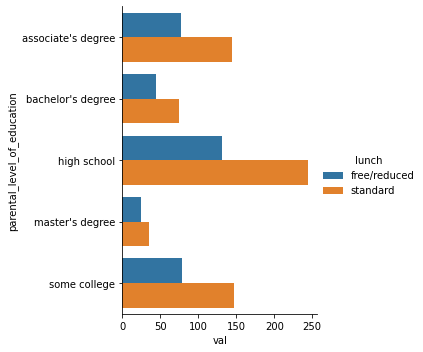

In [145]:
# We can visualize the dependency between level of ed and type of lunch.
# As we have only categorical data, we will draw a barplot
sns.catplot(x="val", y="parental_level_of_education", hue="lunch", kind="bar", data=df_ed)

# We do not notice any strong dependency here. 

In [146]:
# Confusion mtx for these 2 variables
confusion_ed = pd.crosstab(df['parental_level_of_education'], df['lunch'])
confusion_ed

lunch,free/reduced,standard
parental_level_of_education,,
associate's degree,77,145
bachelor's degree,44,74
high school,131,244
master's degree,24,35
some college,79,147


In [147]:
# We have categorical data, so we cannot use usual correlation test. We will use Cramer`s test. 
# It is based on a nominal variation of Pearson’s Chi-Square Test. 
# The output is in the range of [0,1], where 0 means no association and 1 is full association
cramers_corrected_stat(confusion_ed)

# There is no correlation between the level of ed and the type of lunch

0.0

In [148]:
# Now we repeat all steps for the second variable
df_race = df.groupby(['race/ethnicity', "lunch"], as_index=False).count().\
drop(['parental_level_of_education'], axis = 1)
df_race                                                 

,race/ethnicity,lunch,val
0,group A,free/reduced,36
1,group A,standard,53
2,group B,free/reduced,69
3,group B,standard,121
4,group C,free/reduced,114
5,group C,standard,205
6,group D,free/reduced,95
7,group D,standard,167
8,group E,free/reduced,41
9,group E,standard,99


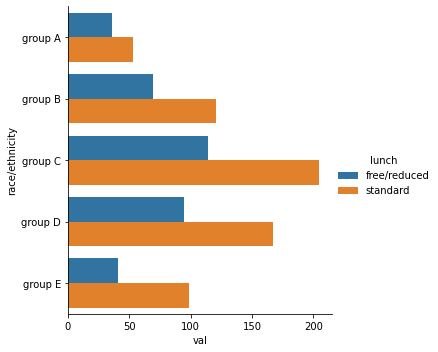

In [149]:
sns.catplot(x="val", y="race/ethnicity", hue="lunch", kind="bar", data=df_race)

In [150]:
confusion_race = pd.crosstab(df['race/ethnicity'], df['lunch'])
cramers_corrected_stat(confusion_race)

# No correlation as well.

0.0